In [1]:
import time
import sys
import numpy as np
import pandas as pd
from sklearn.cross_validation import train_test_split, KFold
import multiprocessing
import os
from scipy import sparse

/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from scipy.stats import spearmanr, pearsonr
from sklearn import ensemble

In [3]:
import datetime as dt
from datetime import date
import calendar
from calendar import weekday, day_name

In [4]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import scipy as sp

/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [5]:
from patsy import dmatrix
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import scipy as sp
from sklearn.datasets import make_regression

In [6]:
def get_holidays(fpath):
    
    f = open(fpath)
    lines = f.readlines()
    lines = [line.split(" ")[:3] for line in lines]
    lines = ["{} {} {}".format(line[0], line[1], line[2]) for line in lines]
    lines = pd.to_datetime(lines)
    return pd.DataFrame({"date2":lines})

In [7]:
def get_holiday_names(fpath):
    # holiday_names are holidays + around Black Fridays
    
    f = open(fpath)
    lines = f.readlines()
    lines = [line.strip().split(" ")[:4] for line in lines]
    lines_dt = ["{} {} {}".format(line[0], line[1], line[2]) for line in lines]
    lines_dt = pd.to_datetime(lines_dt)
    lines_hol = [line[3] for line in lines]
    return pd.DataFrame({"date2":lines_dt, "holiday_name":lines_hol})

In [8]:
def preprocess(_df, is_train):
    
    df = _df.copy()
    
    # date
    df['date2'] = pd.to_datetime(df['date'])
    
    # weekday
    df['weekday'] = df.date2.dt.weekday
    df['is_weekend'] = df.date2.dt.weekday.isin([5,6])
    df['is_holiday'] = df.date2.isin(holidays.date2)
    df['is_holiday_weekday'] = df.is_holiday & (df.is_weekend == False)
    df['is_holiday_weekend'] = df.is_holiday &  df.is_weekend

    # bool to int (maybe no meaning)
    df.is_weekend = np.where(df.is_weekend, 1, 0)
    df.is_holiday = np.where(df.is_holiday, 1, 0)
    df.is_holiday_weekday = np.where(df.is_holiday_weekday, 1, 0)
    df.is_holiday_weekend = np.where(df.is_holiday_weekend, 1, 0)
    
    # day, month, year
    df['day'] = df.date2.dt.day
    df['month'] = df.date2.dt.month
    df['year'] = df.date2.dt.year
    
    # around BlackFriday
    df = pd.merge(df, holiday_names, on='date2', how = 'left')
    df.loc[df.holiday_name.isnull(), "holiday_name"] = ""

    around_BlackFriday = ["BlackFridayM3", "BlackFridayM2", "ThanksgivingDay", "BlackFriday",
                          "BlackFriday1", "BlackFriday2", "BlackFriday3"]
    df["around_BlackFriday"] = np.where(df.holiday_name.isin(around_BlackFriday), 
                                        df.holiday_name, "Else")

    return df

In [11]:
# read dataframes
train = pd.read_csv("data/train.csv")
key = pd.read_csv("data/key.csv")
wtr = pd.read_csv("data/weather.csv")
holidays = get_holidays("holidays.txt")
holiday_names = get_holiday_names("holiday_names.txt")

In [12]:
result = pd.merge(train, key, how='outer')
result

date  store_nbr  item_nbr  units  station_nbr
0        2012-01-01          1         1      0            1
1        2012-01-01          1         2      0            1
2        2012-01-01          1         3      0            1
3        2012-01-01          1         4      0            1
4        2012-01-01          1         5      0            1
5        2012-01-01          1         6      0            1
6        2012-01-01          1         7      0            1
7        2012-01-01          1         8      0            1
8        2012-01-01          1         9     29            1
9        2012-01-01          1        10      0            1
10       2012-01-01          1        11      0            1
11       2012-01-01          1        12      0            1
12       2012-01-01          1        13      0            1
13       2012-01-01          1        14      0            1
14       2012-01-01          1        15      0            1
15       2012-01-01          1        16      0            1
16       2012-01-01          1        17      0            1
17       2012-01-01          1        18      0            1
18       2012-01-01          1        19      0            1
19       2012-01-01          1        20      0            1
20       2012-01-01          1        21      0            1
21       2012-01-01          1        22      0            1
22       2012-01-01          1        23      0            1
23       2012-01-01          1        24      0            1
24       2012-01-01          1        25      0            1
25       2012-01-01          1        26      0            1
26       2012-01-01          1        27      0            1
27       2012-01-01          1        28      2            1
28       2012-01-01          1        29      0            1
29       2012-01-01          1        30      0            1
...             ...        ...       ...    ...          ...
4617570  2014-10-31         35        82      0            5
4617571  2014-10-31         35        83      0            5
4617572  2014-10-31         35        84      0            5
4617573  2014-10-31         35        85      0            5
4617574  2014-10-31         35        86      0            5
4617575  2014-10-31         35        87      0            5
4617576  2014-10-31         35        88      0            5
4617577  2014-10-31         35        89      0            5
4617578  2014-10-31         35        90      0            5
4617579  2014-10-31         35        91      0            5
4617580  2014-10-31         35        92      0            5
4617581  2014-10-31         35        93      0            5
4617582  2014-10-31         35        94      0            5
4617583  2014-10-31         35        95      0            5
4617584  2014-10-31         35        96      0            5
4617585  2014-10-31         35        97      0            5
4617586  2014-10-31         35        98      0            5
4617587  2014-10-31         35        99      0            5
4617588  2014-10-31         35       100      0            5
4617589  2014-10-31         35       101      0            5
4617590  2014-10-31         35       102      0            5
4617591  2014-10-31         35       103      0            5
4617592  2014-10-31         35       104      0            5
4617593  2014-10-31         35       105      0            5
4617594  2014-10-31         35       106      0            5
4617595  2014-10-31         35       107      0            5
4617596  2014-10-31         35       108      0            5
4617597  2014-10-31         35       109      0            5
4617598  2014-10-31         35       110      0            5
4617599  2014-10-31         35       111      0            5

[4617600 rows x 5 columns]

In [13]:
# holiday 전처리
df_train = preprocess(result, True)
df_train

date  store_nbr  item_nbr  units  station_nbr      date2  \
0        2012-01-01          1         1      0            1 2012-01-01   
1        2012-01-01          1         2      0            1 2012-01-01   
2        2012-01-01          1         3      0            1 2012-01-01   
3        2012-01-01          1         4      0            1 2012-01-01   
4        2012-01-01          1         5      0            1 2012-01-01   
5        2012-01-01          1         6      0            1 2012-01-01   
6        2012-01-01          1         7      0            1 2012-01-01   
7        2012-01-01          1         8      0            1 2012-01-01   
8        2012-01-01          1         9     29            1 2012-01-01   
9        2012-01-01          1        10      0            1 2012-01-01   
10       2012-01-01          1        11      0            1 2012-01-01   
11       2012-01-01          1        12      0            1 2012-01-01   
12       2012-01-01          1        13      0            1 2012-01-01   
13       2012-01-01          1        14      0            1 2012-01-01   
14       2012-01-01          1        15      0            1 2012-01-01   
15       2012-01-01          1        16      0            1 2012-01-01   
16       2012-01-01          1        17      0            1 2012-01-01   
17       2012-01-01          1        18      0            1 2012-01-01   
18       2012-01-01          1        19      0            1 2012-01-01   
19       2012-01-01          1        20      0            1 2012-01-01   
20       2012-01-01          1        21      0            1 2012-01-01   
21       2012-01-01          1        22      0            1 2012-01-01   
22       2012-01-01          1        23      0            1 2012-01-01   
23       2012-01-01          1        24      0            1 2012-01-01   
24       2012-01-01          1        25      0            1 2012-01-01   
25       2012-01-01          1        26      0            1 2012-01-01   
26       2012-01-01          1        27      0            1 2012-01-01   
27       2012-01-01          1        28      2            1 2012-01-01   
28       2012-01-01          1        29      0            1 2012-01-01   
29       2012-01-01          1        30      0            1 2012-01-01   
...             ...        ...       ...    ...          ...        ...   
4617570  2014-10-31         35        82      0            5 2014-10-31   
4617571  2014-10-31         35        83      0            5 2014-10-31   
4617572  2014-10-31         35        84      0            5 2014-10-31   
4617573  2014-10-31         35        85      0            5 2014-10-31   
4617574  2014-10-31         35        86      0            5 2014-10-31   
4617575  2014-10-31         35        87      0            5 2014-10-31   
4617576  2014-10-31         35        88      0            5 2014-10-31   
4617577  2014-10-31         35        89      0            5 2014-10-31   
4617578  2014-10-31         35        90      0            5 2014-10-31   
4617579  2014-10-31         35        91      0            5 2014-10-31   
4617580  2014-10-31         35        92      0            5 2014-10-31   
4617581  2014-10-31         35        93      0            5 2014-10-31   
4617582  2014-10-31         35        94      0            5 2014-10-31   
4617583  2014-10-31         35        95      0            5 2014-10-31   
4617584  2014-10-31         35        96      0            5 2014-10-31   
4617585  2014-10-31         35        97      0            5 2014-10-31   
4617586  2014-10-31         35        98      0            5 2014-10-31   
4617587  2014-10-31         35        99      0            5 2014-10-31   
4617588  2014-10-31         35       100      0            5 2014-10-31   
4617589  2014-10-31         35       101      0            5 2014-10-31   
4617590  2014-10-31         35       102      0            5 2014-10-31   
4617591  2014-10-31         35       103

In [15]:
# 모든 데이터 merge
all_df = pd.merge(df_train, wtr, on=['date', 'station_nbr'], how='left')
all_df

date  store_nbr  item_nbr  units  station_nbr      date2  \
0        2012-01-01          1         1      0            1 2012-01-01   
1        2012-01-01          1         2      0            1 2012-01-01   
2        2012-01-01          1         3      0            1 2012-01-01   
3        2012-01-01          1         4      0            1 2012-01-01   
4        2012-01-01          1         5      0            1 2012-01-01   
5        2012-01-01          1         6      0            1 2012-01-01   
6        2012-01-01          1         7      0            1 2012-01-01   
7        2012-01-01          1         8      0            1 2012-01-01   
8        2012-01-01          1         9     29            1 2012-01-01   
9        2012-01-01          1        10      0            1 2012-01-01   
10       2012-01-01          1        11      0            1 2012-01-01   
11       2012-01-01          1        12      0            1 2012-01-01   
12       2012-01-01          1        13      0            1 2012-01-01   
13       2012-01-01          1        14      0            1 2012-01-01   
14       2012-01-01          1        15      0            1 2012-01-01   
15       2012-01-01          1        16      0            1 2012-01-01   
16       2012-01-01          1        17      0            1 2012-01-01   
17       2012-01-01          1        18      0            1 2012-01-01   
18       2012-01-01          1        19      0            1 2012-01-01   
19       2012-01-01          1        20      0            1 2012-01-01   
20       2012-01-01          1        21      0            1 2012-01-01   
21       2012-01-01          1        22      0            1 2012-01-01   
22       2012-01-01          1        23      0            1 2012-01-01   
23       2012-01-01          1        24      0            1 2012-01-01   
24       2012-01-01          1        25      0            1 2012-01-01   
25       2012-01-01          1        26      0            1 2012-01-01   
26       2012-01-01          1        27      0            1 2012-01-01   
27       2012-01-01          1        28      2            1 2012-01-01   
28       2012-01-01          1        29      0            1 2012-01-01   
29       2012-01-01          1        30      0            1 2012-01-01   
...             ...        ...       ...    ...          ...        ...   
4617570  2014-10-31         35        82      0            5 2014-10-31   
4617571  2014-10-31         35        83      0            5 2014-10-31   
4617572  2014-10-31         35        84      0            5 2014-10-31   
4617573  2014-10-31         35        85      0            5 2014-10-31   
4617574  2014-10-31         35        86      0            5 2014-10-31   
4617575  2014-10-31         35        87      0            5 2014-10-31   
4617576  2014-10-31         35        88      0            5 2014-10-31   
4617577  2014-10-31         35        89      0            5 2014-10-31   
4617578  2014-10-31         35        90      0            5 2014-10-31   
4617579  2014-10-31         35        91      0            5 2014-10-31   
4617580  2014-10-31         35        92      0            5 2014-10-31   
4617581  2014-10-31         35        93      0            5 2014-10-31   
4617582  2014-10-31         35        94      0            5 2014-10-31   
4617583  2014-10-31         35        95      0            5 2014-10-31   
4617584  2014-10-31         35        96      0            5 2014-10-31   
4617585  2014-10-31         35        97      0            5 2014-10-31   
4617586  2014-10-31         35        98      0            5 2014-10-31   
4617587  2014-10-31         35        99      0            5 2014-10-31   
4617588  2014-10-31         35       100      0            5 2014-10-31   
4617589  2014-10-31         35       101      0            5 2014-10-31   
4617590  2014-10-31         35       102      0            5 2014-10-31   
4617591  2014-10-31         35       103

In [16]:
all_df.columns

Index(['date', 'store_nbr', 'item_nbr', 'units', 'station_nbr', 'date2',
       'weekday', 'is_weekend', 'is_holiday', 'is_holiday_weekday',
       'is_holiday_weekend', 'day', 'month', 'year', 'holiday_name',
       'around_BlackFriday', 'tmax', 'tmin', 'tavg', 'depart', 'dewpoint',
       'wetbulb', 'heat', 'cool', 'sunrise', 'sunset', 'codesum', 'snowfall',
       'preciptotal', 'stnpressure', 'sealevel', 'resultspeed', 'resultdir',
       'avgspeed'],
      dtype='object')

In [17]:
# codesum 컬럼 삭제
all_df2 = all_df.drop('codesum', axis=1)
all_df2

date  store_nbr  item_nbr  units  station_nbr      date2  \
0        2012-01-01          1         1      0            1 2012-01-01   
1        2012-01-01          1         2      0            1 2012-01-01   
2        2012-01-01          1         3      0            1 2012-01-01   
3        2012-01-01          1         4      0            1 2012-01-01   
4        2012-01-01          1         5      0            1 2012-01-01   
5        2012-01-01          1         6      0            1 2012-01-01   
6        2012-01-01          1         7      0            1 2012-01-01   
7        2012-01-01          1         8      0            1 2012-01-01   
8        2012-01-01          1         9     29            1 2012-01-01   
9        2012-01-01          1        10      0            1 2012-01-01   
10       2012-01-01          1        11      0            1 2012-01-01   
11       2012-01-01          1        12      0            1 2012-01-01   
12       2012-01-01          1        13      0            1 2012-01-01   
13       2012-01-01          1        14      0            1 2012-01-01   
14       2012-01-01          1        15      0            1 2012-01-01   
15       2012-01-01          1        16      0            1 2012-01-01   
16       2012-01-01          1        17      0            1 2012-01-01   
17       2012-01-01          1        18      0            1 2012-01-01   
18       2012-01-01          1        19      0            1 2012-01-01   
19       2012-01-01          1        20      0            1 2012-01-01   
20       2012-01-01          1        21      0            1 2012-01-01   
21       2012-01-01          1        22      0            1 2012-01-01   
22       2012-01-01          1        23      0            1 2012-01-01   
23       2012-01-01          1        24      0            1 2012-01-01   
24       2012-01-01          1        25      0            1 2012-01-01   
25       2012-01-01          1        26      0            1 2012-01-01   
26       2012-01-01          1        27      0            1 2012-01-01   
27       2012-01-01          1        28      2            1 2012-01-01   
28       2012-01-01          1        29      0            1 2012-01-01   
29       2012-01-01          1        30      0            1 2012-01-01   
...             ...        ...       ...    ...          ...        ...   
4617570  2014-10-31         35        82      0            5 2014-10-31   
4617571  2014-10-31         35        83      0            5 2014-10-31   
4617572  2014-10-31         35        84      0            5 2014-10-31   
4617573  2014-10-31         35        85      0            5 2014-10-31   
4617574  2014-10-31         35        86      0            5 2014-10-31   
4617575  2014-10-31         35        87      0            5 2014-10-31   
4617576  2014-10-31         35        88      0            5 2014-10-31   
4617577  2014-10-31         35        89      0            5 2014-10-31   
4617578  2014-10-31         35        90      0            5 2014-10-31   
4617579  2014-10-31         35        91      0            5 2014-10-31   
4617580  2014-10-31         35        92      0            5 2014-10-31   
4617581  2014-10-31         35        93      0            5 2014-10-31   
4617582  2014-10-31         35        94      0            5 2014-10-31   
4617583  2014-10-31         35        95      0            5 2014-10-31   
4617584  2014-10-31         35        96      0            5 2014-10-31   
4617585  2014-10-31         35        97      0            5 2014-10-31   
4617586  2014-10-31         35        98      0            5 2014-10-31   
4617587  2014-10-31         35        99      0            5 2014-10-31   
4617588  2014-10-31         35       100      0            5 2014-10-31   
4617589  2014-10-31         35       101      0            5 2014-10-31   
4617590  2014-10-31         35       102      0            5 2014-10-31   
4617591  2014-10-31         35       103

In [19]:
# M, T, - 값 -9999로 변환
all_df3 = all_df2.replace({'M': -9999, 'T': -9999, '-': -9999})
all_df3

date  store_nbr  item_nbr  units  station_nbr      date2  \
0        2012-01-01          1         1      0            1 2012-01-01   
1        2012-01-01          1         2      0            1 2012-01-01   
2        2012-01-01          1         3      0            1 2012-01-01   
3        2012-01-01          1         4      0            1 2012-01-01   
4        2012-01-01          1         5      0            1 2012-01-01   
5        2012-01-01          1         6      0            1 2012-01-01   
6        2012-01-01          1         7      0            1 2012-01-01   
7        2012-01-01          1         8      0            1 2012-01-01   
8        2012-01-01          1         9     29            1 2012-01-01   
9        2012-01-01          1        10      0            1 2012-01-01   
10       2012-01-01          1        11      0            1 2012-01-01   
11       2012-01-01          1        12      0            1 2012-01-01   
12       2012-01-01          1        13      0            1 2012-01-01   
13       2012-01-01          1        14      0            1 2012-01-01   
14       2012-01-01          1        15      0            1 2012-01-01   
15       2012-01-01          1        16      0            1 2012-01-01   
16       2012-01-01          1        17      0            1 2012-01-01   
17       2012-01-01          1        18      0            1 2012-01-01   
18       2012-01-01          1        19      0            1 2012-01-01   
19       2012-01-01          1        20      0            1 2012-01-01   
20       2012-01-01          1        21      0            1 2012-01-01   
21       2012-01-01          1        22      0            1 2012-01-01   
22       2012-01-01          1        23      0            1 2012-01-01   
23       2012-01-01          1        24      0            1 2012-01-01   
24       2012-01-01          1        25      0            1 2012-01-01   
25       2012-01-01          1        26      0            1 2012-01-01   
26       2012-01-01          1        27      0            1 2012-01-01   
27       2012-01-01          1        28      2            1 2012-01-01   
28       2012-01-01          1        29      0            1 2012-01-01   
29       2012-01-01          1        30      0            1 2012-01-01   
...             ...        ...       ...    ...          ...        ...   
4617570  2014-10-31         35        82      0            5 2014-10-31   
4617571  2014-10-31         35        83      0            5 2014-10-31   
4617572  2014-10-31         35        84      0            5 2014-10-31   
4617573  2014-10-31         35        85      0            5 2014-10-31   
4617574  2014-10-31         35        86      0            5 2014-10-31   
4617575  2014-10-31         35        87      0            5 2014-10-31   
4617576  2014-10-31         35        88      0            5 2014-10-31   
4617577  2014-10-31         35        89      0            5 2014-10-31   
4617578  2014-10-31         35        90      0            5 2014-10-31   
4617579  2014-10-31         35        91      0            5 2014-10-31   
4617580  2014-10-31         35        92      0            5 2014-10-31   
4617581  2014-10-31         35        93      0            5 2014-10-31   
4617582  2014-10-31         35        94      0            5 2014-10-31   
4617583  2014-10-31         35        95      0            5 2014-10-31   
4617584  2014-10-31         35        96      0            5 2014-10-31   
4617585  2014-10-31         35        97      0            5 2014-10-31   
4617586  2014-10-31         35        98      0            5 2014-10-31   
4617587  2014-10-31         35        99      0            5 2014-10-31   
4617588  2014-10-31         35       100      0            5 2014-10-31   
4617589  2014-10-31         35       101      0            5 2014-10-31   
4617590  2014-10-31         35       102      0            5 2014-10-31   
4617591  2014-10-31         35       103

In [27]:
all_df3.to_csv("0_all_M_tf.csv", sep=',', index=None)

In [20]:
all_df3.isnull().sum()

date                  0
store_nbr             0
item_nbr              0
units                 0
station_nbr           0
date2                 0
weekday               0
is_weekend            0
is_holiday            0
is_holiday_weekday    0
is_holiday_weekend    0
day                   0
month                 0
year                  0
holiday_name          0
around_BlackFriday    0
tmax                  0
tmin                  0
tavg                  0
depart                0
dewpoint              0
wetbulb               0
heat                  0
cool                  0
sunrise               0
sunset                0
snowfall              0
preciptotal           0
stnpressure           0
sealevel              0
resultspeed           0
resultdir             0
avgspeed              0
dtype: int64

In [26]:
all_df3['holiday_name'].head(300)

0      NewYearsDay
1      NewYearsDay
2      NewYearsDay
3      NewYearsDay
4      NewYearsDay
5      NewYearsDay
6      NewYearsDay
7      NewYearsDay
8      NewYearsDay
9      NewYearsDay
10     NewYearsDay
11     NewYearsDay
12     NewYearsDay
13     NewYearsDay
14     NewYearsDay
15     NewYearsDay
16     NewYearsDay
17     NewYearsDay
18     NewYearsDay
19     NewYearsDay
20     NewYearsDay
21     NewYearsDay
22     NewYearsDay
23     NewYearsDay
24     NewYearsDay
25     NewYearsDay
26     NewYearsDay
27     NewYearsDay
28     NewYearsDay
29     NewYearsDay
          ...     
270               
271               
272               
273               
274               
275               
276               
277               
278               
279               
280               
281               
282               
283               
284               
285               
286               
287               
288               
289               
290               
291         

In [7]:
df = pd.read_csv("0_all_M_tf.csv", sep=',', low_memory=False)
df

date  store_nbr  item_nbr  units  station_nbr       date2  \
0        2012-01-01          1         1      0            1  2012-01-01   
1        2012-01-01          1         2      0            1  2012-01-01   
2        2012-01-01          1         3      0            1  2012-01-01   
3        2012-01-01          1         4      0            1  2012-01-01   
4        2012-01-01          1         5      0            1  2012-01-01   
5        2012-01-01          1         6      0            1  2012-01-01   
6        2012-01-01          1         7      0            1  2012-01-01   
7        2012-01-01          1         8      0            1  2012-01-01   
8        2012-01-01          1         9     29            1  2012-01-01   
9        2012-01-01          1        10      0            1  2012-01-01   
10       2012-01-01          1        11      0            1  2012-01-01   
11       2012-01-01          1        12      0            1  2012-01-01   
12       2012-01-01          1        13      0            1  2012-01-01   
13       2012-01-01          1        14      0            1  2012-01-01   
14       2012-01-01          1        15      0            1  2012-01-01   
15       2012-01-01          1        16      0            1  2012-01-01   
16       2012-01-01          1        17      0            1  2012-01-01   
17       2012-01-01          1        18      0            1  2012-01-01   
18       2012-01-01          1        19      0            1  2012-01-01   
19       2012-01-01          1        20      0            1  2012-01-01   
20       2012-01-01          1        21      0            1  2012-01-01   
21       2012-01-01          1        22      0            1  2012-01-01   
22       2012-01-01          1        23      0            1  2012-01-01   
23       2012-01-01          1        24      0            1  2012-01-01   
24       2012-01-01          1        25      0            1  2012-01-01   
25       2012-01-01          1        26      0            1  2012-01-01   
26       2012-01-01          1        27      0            1  2012-01-01   
27       2012-01-01          1        28      2            1  2012-01-01   
28       2012-01-01          1        29      0            1  2012-01-01   
29       2012-01-01          1        30      0            1  2012-01-01   
...             ...        ...       ...    ...          ...         ...   
4617570  2014-10-31         35        82      0            5  2014-10-31   
4617571  2014-10-31         35        83      0            5  2014-10-31   
4617572  2014-10-31         35        84      0            5  2014-10-31   
4617573  2014-10-31         35        85      0            5  2014-10-31   
4617574  2014-10-31         35        86      0            5  2014-10-31   
4617575  2014-10-31         35        87      0            5  2014-10-31   
4617576  2014-10-31         35        88      0            5  2014-10-31   
4617577  2014-10-31         35        89      0            5  2014-10-31   
4617578  2014-10-31         35        90      0            5  2014-10-31   
4617579  2014-10-31         35        91      0            5  2014-10-31   
4617580  2014-10-31         35        92      0            5  2014-10-31   
4617581  2014-10-31         35        93      0            5  2014-10-31   
4617582  2014-10-31         35        94      0            5  2014-10-31   
4617583  2014-10-31         35        95      0            5  2014-10-31   
4617584  2014-10-31         35        96      0            5  2014-10-31   
4617585  2014-10-31         35        97      0            5  2014-10-31   
4617586  2014-10-31         35        98      0            5  2014-10-31   
4617587  2014-10-31         35        99      0            5  2014-10-31   
4617588  2014-10-31         35       100      0            5  2014-10-31   
4617589  2014-10-31         35       101      0            5  2014-10-31   
4617590  2014-10-31         35       102      0            5  2

In [8]:
df.columns

Index(['date', 'store_nbr', 'item_nbr', 'units', 'station_nbr', 'date2',
       'weekday', 'is_weekend', 'is_holiday', 'is_holiday_weekday',
       'is_holiday_weekend', 'day', 'month', 'year', 'holiday_name',
       'around_BlackFriday', 'tmax', 'tmin', 'tavg', 'depart', 'dewpoint',
       'wetbulb', 'heat', 'cool', 'sunrise', 'sunset', 'snowfall',
       'preciptotal', 'stnpressure', 'sealevel', 'resultspeed', 'resultdir',
       'avgspeed'],
      dtype='object')

In [9]:
model_1 = sm.OLS.from_formula("units ~ weekday + is_weekend", data=df)
print(model_1.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                  units   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     385.1
Date:                Mon, 12 Mar 2018   Prob (F-statistic):          5.59e-168
Time:                        13:19:47   Log-Likelihood:            -1.7126e+07
No. Observations:             4617600   AIC:                         3.425e+07
Df Residuals:                 4617597   BIC:                         3.425e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9335      0.009    100.813      0.0

In [18]:
ls = list(df.columns)
ls

['date',
 'store_nbr',
 'item_nbr',
 'units',
 'station_nbr',
 'date2',
 'weekday',
 'is_weekend',
 'is_holiday',
 'is_holiday_weekday',
 'is_holiday_weekend',
 'day',
 'month',
 'year',
 'holiday_name',
 'around_BlackFriday',
 'tmax',
 'tmin',
 'tavg',
 'depart',
 'dewpoint',
 'wetbulb',
 'heat',
 'cool',
 'sunrise',
 'sunset',
 'snowfall',
 'preciptotal',
 'stnpressure',
 'sealevel',
 'resultspeed',
 'resultdir',
 'avgspeed']

In [8]:
dfy_new = result_2.predict(dfX)

plt.scatter(dfy, dfy_new)
#plt.title("")
plt.xlabel("real value")
plt.ylabel("prediction value")
plt.show()

NameError: name 'result_2' is not defined

In [ ]:
influence = result_2.get_influence()
hat = influence.hat_matrix_diag
print("레버리지의 합 :", hat.sum())
plt.figure(figsize=(10, 2))
plt.stem(hat)
plt.show()

In [ ]:
# 레버리지의 평균값 구하기
#float(hat.sum) / float(len(df_item.index))
print(type(len(df_item.index)))
print(type((hat.sum())))

a = hat.sum() / len(df_item.index)
a 

In [ ]:
# 레버리지 값이 약 0.03을 넘는 데이터를 찾는다
a * 4

In [ ]:
ax = plt.subplot()
plt.scatter(dfy, dfy_new)
sm.graphics.abline_plot(model_results=result_sto_item, ax=ax)
plt.show()

idx = hat > (a * 4)
plt.scatter(dfy[idx], dfy_new[idx], s=300, c="r", alpha=0.5)
plt.show()

In [ ]:
idx = hat < (a * 4)
plt.scatter(dfy[idx], dfy_new[idx])
plt.show()

In [ ]:
df_item2 = df_item.iloc[idx, :]
df_item2

In [7]:
store_df = pd.read_csv("model_OLS.csv", sep=',')
store_df

store_nbr  R square  F_statics  Prob(F_statics)       AIC       BIC  \
0           1.0     0.017      41.36              0.0  546400.0  546900.0   
1           NaN       NaN        NaN              NaN       NaN       NaN   
2           NaN       NaN        NaN              NaN       NaN       NaN   
3           NaN       NaN        NaN              NaN       NaN       NaN   
4           NaN       NaN        NaN              NaN       NaN       NaN   
5           NaN       NaN        NaN              NaN       NaN       NaN   
6           NaN       NaN        NaN              NaN       NaN       NaN   
7           NaN       NaN        NaN              NaN       NaN       NaN   
8           NaN       NaN        NaN              NaN       NaN       NaN   
9           NaN       NaN        NaN              NaN       NaN       NaN   
10          NaN       NaN        NaN              NaN       NaN       NaN   
11          NaN       NaN        NaN              NaN       NaN       NaN   
12          NaN       NaN        NaN              NaN       NaN       NaN   
13          NaN       NaN        NaN              NaN       NaN       NaN   
14          NaN       NaN        NaN              NaN       NaN       NaN   
15          NaN       NaN        NaN              NaN       NaN       NaN   
16          NaN       NaN        NaN              NaN       NaN       NaN   
17          NaN       NaN        NaN              NaN       NaN       NaN   
18          NaN       NaN        NaN              NaN       NaN       NaN   
19          NaN       NaN        NaN              NaN       NaN       NaN   
20          NaN       NaN        NaN              NaN       NaN       NaN   
21          NaN       NaN        NaN              NaN       NaN       NaN   
22          NaN       NaN        NaN              NaN       NaN       NaN   
23          NaN       NaN        NaN              NaN       NaN       NaN   
24          NaN       NaN        NaN              NaN       NaN       NaN   
25          NaN       NaN        NaN              NaN       NaN       NaN   
26          NaN       NaN        NaN              NaN       NaN       NaN   
27          NaN       NaN        NaN              NaN       NaN       NaN   
28          NaN       NaN        NaN              NaN       NaN       NaN   
29          NaN       NaN        NaN              NaN       NaN       NaN   
...         ...       ...        ...              ...       ...       ...   
2624        NaN       NaN        NaN              NaN       NaN       NaN   
2625        NaN       NaN        NaN              NaN       NaN       NaN   
2626        NaN       NaN        NaN              NaN       NaN       NaN   
2627        NaN       NaN        NaN              NaN       NaN       NaN   
2628        NaN       NaN        NaN              NaN       NaN       NaN   
2629        NaN       NaN        NaN              NaN       NaN       NaN   
2630        NaN       NaN        NaN              NaN       NaN       NaN   
2631        NaN       NaN        NaN              NaN       NaN       NaN   
2632        NaN       NaN        NaN              NaN       NaN       NaN   
2633        NaN       NaN        NaN              NaN       NaN       NaN   
2634        NaN       NaN        NaN              NaN       NaN       NaN   
2635        NaN       NaN        NaN              NaN       NaN       NaN   
2636        NaN       NaN        NaN              NaN       NaN       NaN   
2637        NaN       NaN        NaN              NaN       NaN       NaN   
2638        NaN       NaN        NaN              NaN       NaN       NaN   
2639        NaN       NaN        NaN              NaN       NaN       NaN   
2640        NaN       NaN        NaN              NaN       NaN       NaN   
2641        NaN       NaN        NaN              NaN       NaN       NaN   
2642        NaN       NaN        NaN              NaN       NaN       NaN   
2643        NaN       NaN        NaN              NaN       NaN       NaN   
26

In [1]:
from sklearn.datasets import load_boston
boston = load_boston()

In [2]:
dfX = pd.DataFrame(boston.data, columns=boston.feature_names)
dfy = pd.DataFrame(boston.target, columns=["MEDV"])
df = pd.concat([dfX, dfy], axis=1)
df.tail()

CRIM   ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
501  0.06263  0.0  11.93   0.0  0.573  6.593  69.1  2.4786  1.0  273.0   
502  0.04527  0.0  11.93   0.0  0.573  6.120  76.7  2.2875  1.0  273.0   
503  0.06076  0.0  11.93   0.0  0.573  6.976  91.0  2.1675  1.0  273.0   
504  0.10959  0.0  11.93   0.0  0.573  6.794  89.3  2.3889  1.0  273.0   
505  0.04741  0.0  11.93   0.0  0.573  6.030  80.8  2.5050  1.0  273.0   

     PTRATIO       B  LSTAT  MEDV  
501     21.0  391.99   9.67  22.4  
502     21.0  396.90   9.08  20.6  
503     21.0  396.90   5.64  23.9  
504     21.0  393.45   6.48  22.0  
505     21.0  396.90   7.88  11.9

In [3]:
boston.feature_names

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

In [ ]:
가격, DIS, PTRATIO, LSTAT

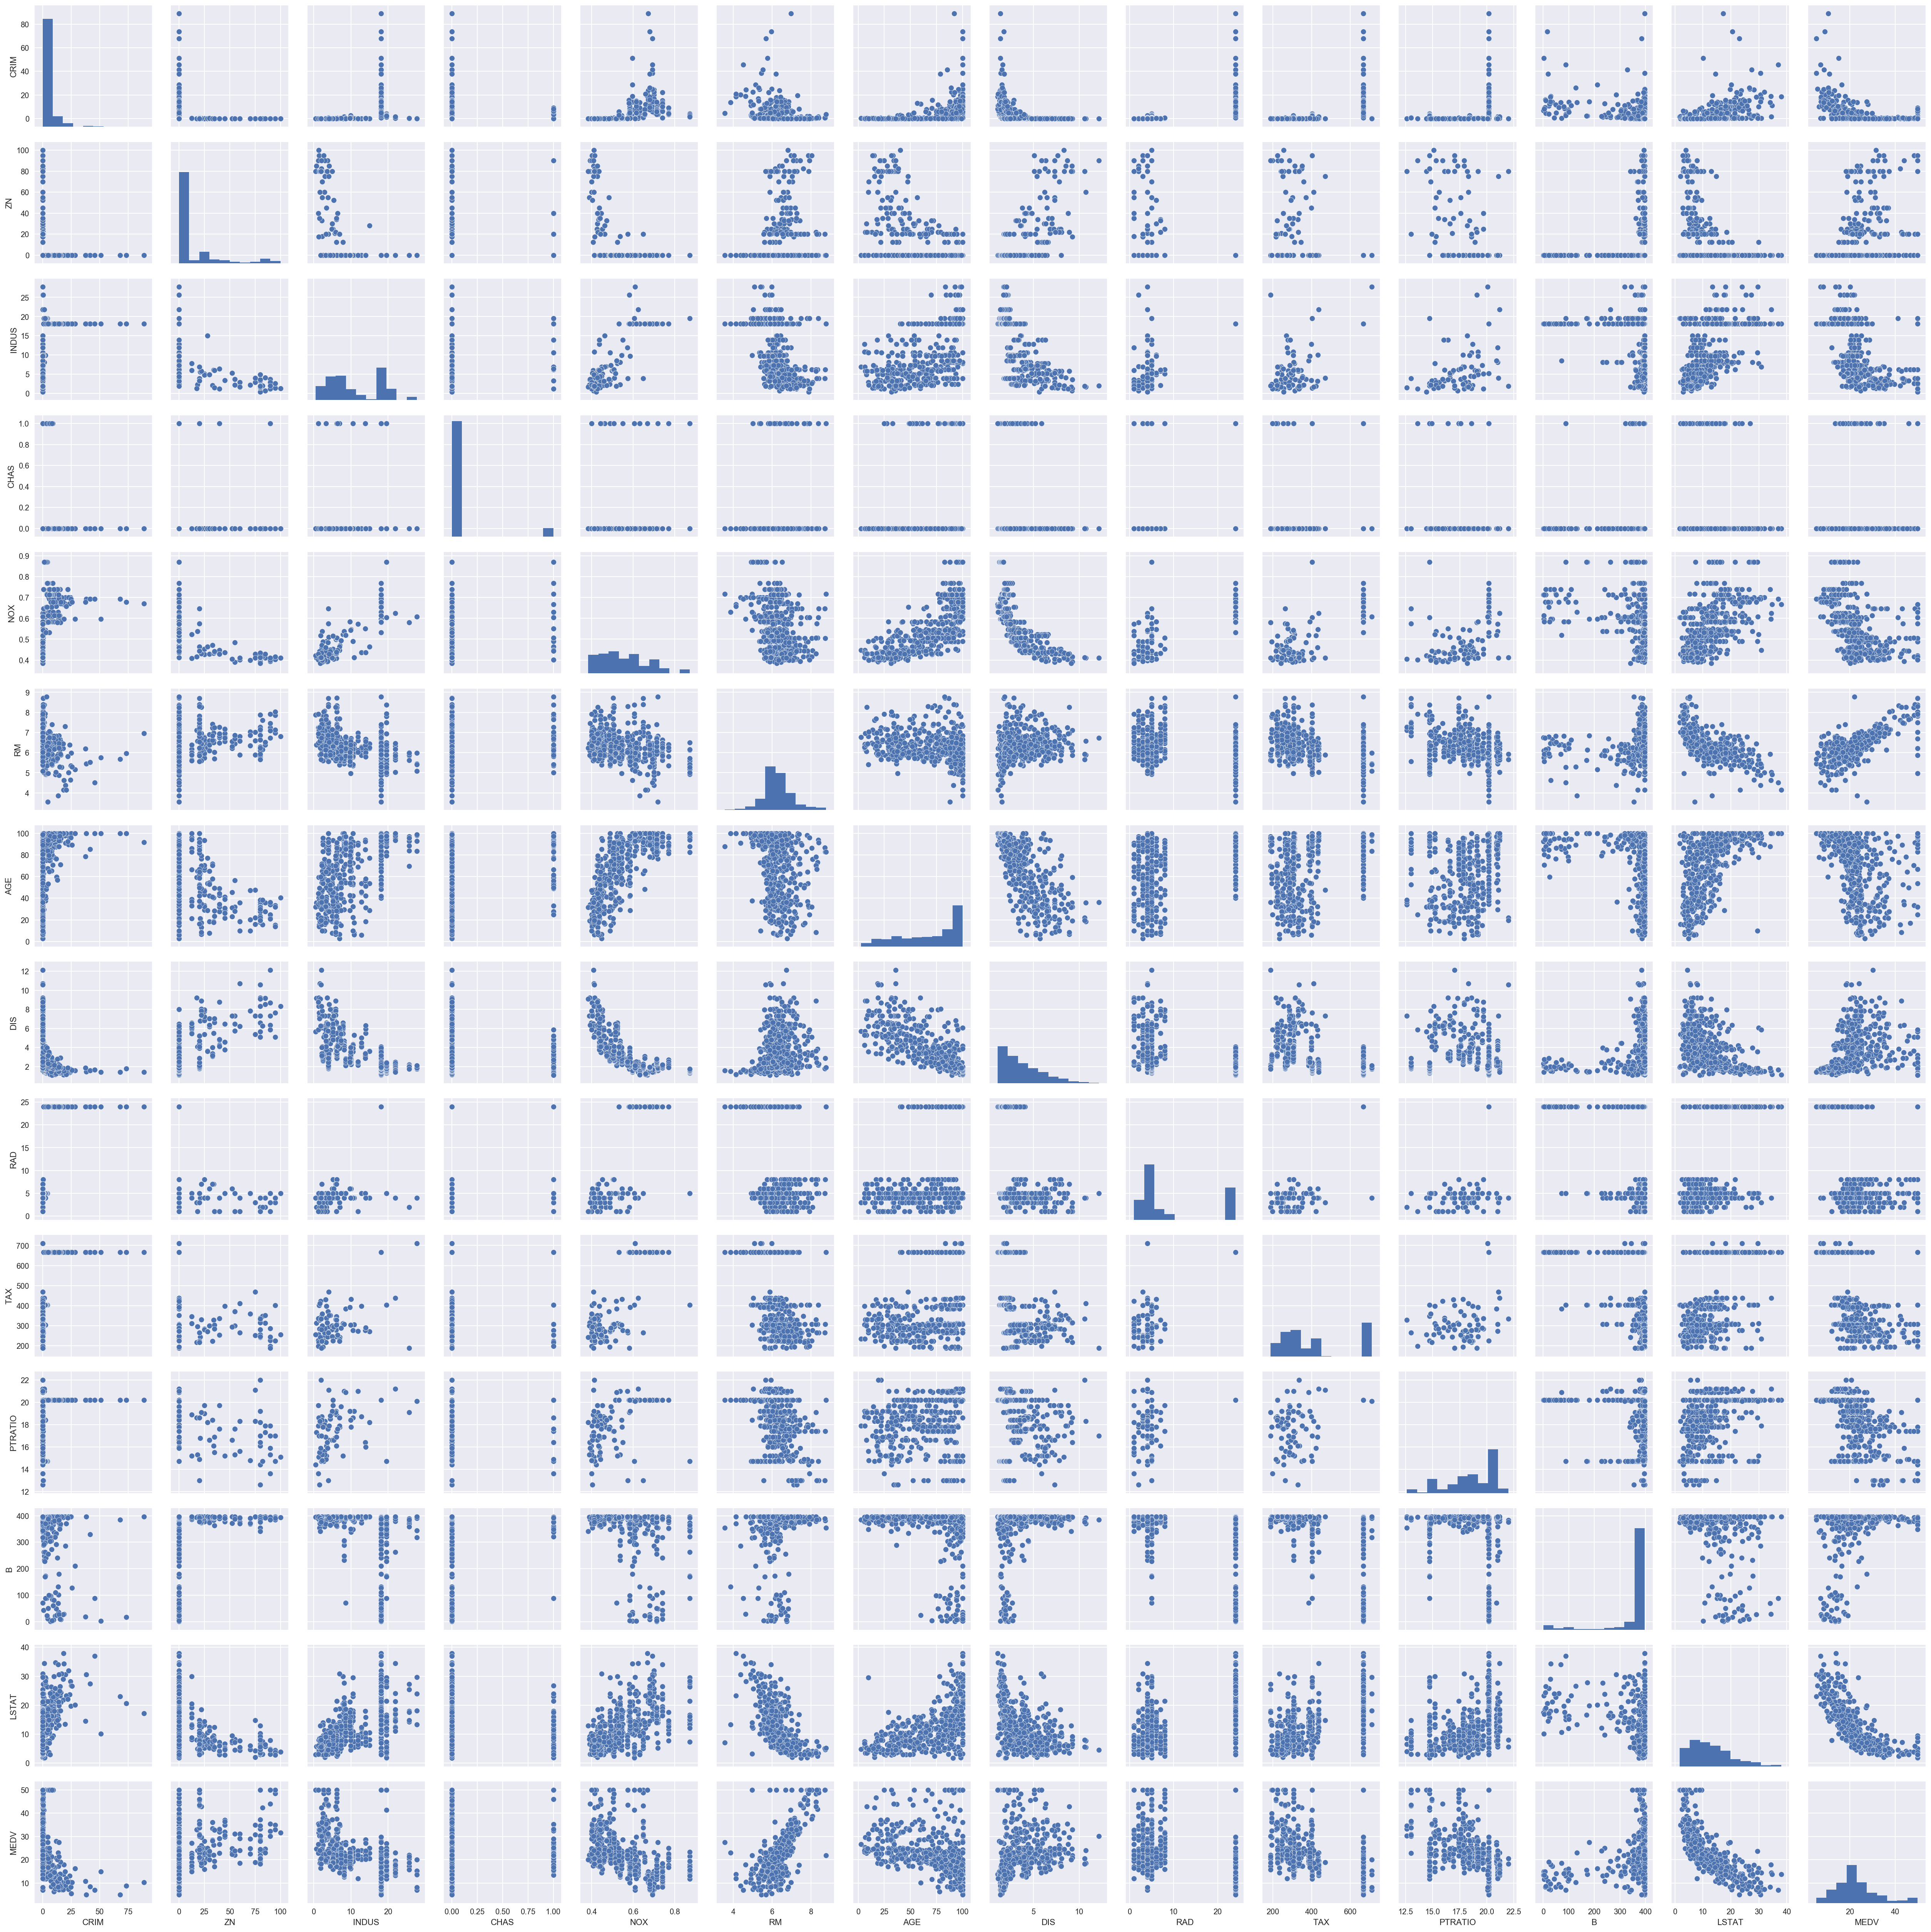

In [4]:
cols = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
sns.pairplot(df[cols])
plt.show()

In [ ]:
# 안됨
"units ~ C(item_nbr) + C(weekday) +"
                                     "is_weekend + is_holiday_weekday + "
                                     "is_holiday_weekend + "
                                     "scale(tmax) + scale(tmin) + scale(tavg) + scale(depart) + scale(dewpoint) + scale(wetbulb) + scale(heat) + scale(cool) + scale(sunrise) + "
                                     "scale(sunset) + scale(snowfall) + scale(preciptotal) + scale(stnpressure) + scale(sealevel) + scale(resultspeed) + scale(resultdir) +"
                                     "scale(avgspeed)"

In [ ]:
# test1
"units ~ C(item_nbr) + C(weekday) +"
                                     "is_weekend + is_holiday_weekday + "
                                     "is_holiday_weekend + "
                                     "tmax + tmin + tavg + depart + dewpoint + wetbulb + heat + cool + sunrise + "
                                     "sunset + snowfall + preciptotal + stnpressure + sealevel + resultspeed + resultdir +"
                                     "avgspeed"

In [ ]:
# test2
"units ~ C(item_nbr) + C(weekday) +"
                                     "is_weekend + is_holiday_weekday + "
                                     "is_holiday_weekend + "
                                     "tmax + tmin + depart + dewpoint + wetbulb + sunrise + "
                                     "sunset + snowfall + preciptotal + stnpressure + sealevel + resultspeed + resultdir +"
                                     "avgspeed"

In [ ]:
# test3
"units ~ C(item_nbr) + C(weekday) + "
                                     "is_weekend + "
                                     "tmax + tmin + depart + dewpoint + wetbulb + sunrise + "
                                     "sunset + snowfall + preciptotal + stnpressure + sealevel + resultspeed + resultdir +"
                                     "avgspeed"

In [ ]:
# test4
"np.log1p(units) ~ C(item_nbr) + C(weekday) + "
                                     "is_weekend + "
                                     "tmax + tmin + depart + dewpoint + wetbulb + sunrise + "
                                     "sunset + snowfall + preciptotal + stnpressure + sealevel + resultspeed + resultdir +"
                                     "avgspeed"

In [ ]:
# 안됨
"np.log(units) ~ C(item_nbr) + C(weekday) + "
                                     "is_weekend + "
                                     "np.log(tmax) + np.log(tmin) + np.log(depart) + np.log(dewpoint) + np.log(wetbulb) + np.log(sunrise) + "
                                     "np.log(sunset) + np.log(snowfall) + np.log(preciptotal) + np.log(stnpressure) + np.log(sealevel) + np.log(resultspeed) + np.log(resultdir) +"
                                     "np.log(avgspeed)"

In [ ]:
# 안됨
"units ~ C(item_nbr) + C(weekday) + C(around_BlackFriday) + "
                                     "is_weekend + "
                                     "tmax + tmin + depart + dewpoint + wetbulb + sunrise + "
                                     "sunset + snowfall + preciptotal + stnpressure + sealevel + resultspeed + resultdir +"
                                     "avgspeed"

In [ ]:
# typeerror
"math.log(units) ~ C(item_nbr) + C(weekday) + "
                                     "is_weekend + "
                                     "math.log(tmax) + math.log(tmin) + math.log(depart) + math.log(dewpoint) + math.log(wetbulb) + math.log(sunrise) + "
                                     "math.log(sunset) + math.log(snowfall) + math.log(preciptotal) + math.log(stnpressure) + math.log(sealevel) + math.log(resultspeed) + math.log(resultdir) +"
                                     "math.log(avgspeed)"